In [1]:
import torch
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
from torch import nn, optim
from torch.autograd import Variable
import numpy as np
import os
import glob
import xarray as xr
from sklearn import preprocessing
import netCDF4 as nc
import matplotlib.pyplot as plt



np.random.seed(14)  # For reproducibility
torch.manual_seed(14)  # For reproducibility

# Dataloader

### Create input and output channels

In [2]:
# function that splits datasets along the spacial axes and concats them back into single array under time

def normalize(data):
    #normalized_data =  (data - data.mean(skipna=True).values)/data.std(skipna=True).values
    normalized_data = (data - np.mean(data))/np.std(data)
    return normalized_data


def load_norm_data(var_name_string):
    PATH_LIST = glob.glob(BASE+'*/preprocessed_data/'+var_name_string+'.nc') 
    data_app = normalize(xr.open_dataarray(PATH_LIST[0]).to_numpy()[:,5:-5,5:-5])
    for i_file in np.arange(1,len(PATH_LIST)):
        PATH = PATH_LIST[i_file]
        data = xr.open_dataarray(PATH).to_numpy()[:,5:-5,5:-5]
        data_norm = normalize(data)
        data_app = np.concatenate((data_app,data_norm),axis=0)
    return data_app

# depth of CNN * (kernel_num-1)/2
#def load_norm_data_out(var_name_string): #with cropping for output
#    PATH_LIST = glob.glob(BASE+'*/preprocessed_data/'+var_name_string+'.nc') 
#    data_app = normalize(xr.open_dataarray(PATH_LIST[0]).to_numpy()[:,14:-14,14:-14])
#    for i_file in np.arange(1,len(PATH_LIST)):
#        PATH = PATH_LIST[i_file]
#        data = xr.open_dataarray(PATH).to_numpy()[:,14:-14,14:-14]
#        data_norm = normalize(data)
#        data_app = np.concatenate((data_app,data_norm),axis=0)
#    return data_app


def split_data(data):
    data_split_halfs = np.concatenate((np.split(data,2,axis=1)[0],np.split(data,2,axis=1)[1]),0)
    data_split_quarters = np.concatenate((np.split(data_split_halfs,2,axis=2)[0],np.split(data_split_halfs,2,axis=2)[1]),0)
    return data_split_quarters



def load_split_norm_data(var_name_string):
    loaded_data = load_norm_data(var_name_string)
    splitted_data = split_data(loaded_data)
    return splitted_data
    
    
def load_split_norm_data_out(var_name_string):
    loaded_data = load_norm_data(var_name_string)
    splitted_data = split_data(loaded_data)
    cropped_output = splitted_data[:,5:-5,5:-5] # for a kernel of size 3 with 5 conv layers
    return cropped_output


In [3]:
# load preprocessed data, convert to numpy and stack channels

BASE = '/scratch/ab10313/submeso_ML_data/'
FULL_PATH_PP = glob.glob(BASE+'*/preprocessed_data/')

# X INPUT
ds_Bm = load_split_norm_data('Bm_MLD_lowres')
ds_Um = load_split_norm_data('Um_MLD_lowres')
ds_Vm = load_split_norm_data('Vm_MLD_lowres')
ds_Wm = load_split_norm_data('Wm_MLD_lowres')


X_input = np.stack([ds_Bm,ds_Um,ds_Vm,ds_Wm],axis=1)
print('X input shape:')
print( X_input.shape)
print('')


# Y OUTPUT
ds_UsBs = load_split_norm_data('UsBs_MLD_lowres')
ds_VsBs = load_split_norm_data('VsBs_MLD_lowres')
ds_WsBs = load_split_norm_data('WsBs_MLD_lowres')

Y_output = np.stack([ds_UsBs,ds_VsBs,ds_WsBs],axis=1)
print('Y output shape:')
print(Y_output.shape)
print('')


# GRAD B
ds_Bm_x = load_split_norm_data('Bm_x_MLD_lowres')
ds_Bm_y = load_split_norm_data('Bm_y_MLD_lowres')
ds_Bm_z = load_split_norm_data('Bm_z_MLD_lowres')

grad_b = np.stack([ds_Bm_x,ds_Bm_y,ds_Bm_z],axis=1)
print('grad b shape:')
print( grad_b.shape)


X input shape:
(8600, 4, 15, 15)

Y output shape:
(8600, 3, 15, 15)

grad b shape:
(8600, 3, 15, 15)


### randomly generate train, test and validation sets

In [4]:
# TRAIN AND TEST ONLY
# randomnly generate train, test and validation time indecies 
import random
time_ind = X_input.shape[0]
rand_ind = np.arange(time_ind)
rand_seed = 14
random.Random(rand_seed).shuffle(rand_ind)
train_percent = 0.9
test_percent = 0.1 
print(f"Dataset: train {np.round(train_percent*100)}%, test {np.round(test_percent*100)}%")
train_ind, test_ind =  rand_ind[:round(train_percent*time_ind)], rand_ind[round((train_percent)*time_ind):]                                                                        

# check no overlapping indecies
if np.intersect1d(train_ind, test_ind).any():
    print('overlapping indecies')
else:
    print ('no overlapping indecies')
    

Dataset: train 90.0%, test 10.0%
no overlapping indecies


### defined train, test and val dataloaders

In [5]:
# Define X,Y pairs (state, subgrid fluxes) for local network.local_torch_dataset = Data.TensorDataset(
BATCH_SIZE = 64  # Number of sample in each batch


###### training dataset #######
torch_dataset_train = Data.TensorDataset(
    torch.from_numpy(X_input[train_ind]).double(),
    torch.from_numpy(Y_output[train_ind]).double(),
)

loader_train = Data.DataLoader(
    dataset=torch_dataset_train, batch_size=BATCH_SIZE, shuffle=True
)
print('TRAIN')
print('X input shape:')
print( X_input[train_ind].shape)
print('Y output shape:')
print( Y_output[train_ind].shape)
print('')

###### test dataset #######
torch_dataset_test = Data.TensorDataset(
    torch.from_numpy(X_input[test_ind]).double(),
    torch.from_numpy(Y_output[test_ind]).double(),    
)

BATCH_SIZE_TEST = len(torch_dataset_test)

loader_test = Data.DataLoader(
    dataset=torch_dataset_test, batch_size=BATCH_SIZE_TEST, shuffle=True
)

print('TEST')
print('X input shape:')
print( X_input[test_ind].shape)
print('Y output shape:')
print( Y_output[test_ind].shape)
print('')

###### validation dataset #######
#torch_dataset_val = Data.TensorDataset(
#    torch.from_numpy(X_input[val_ind]).double(),
#    torch.from_numpy(Y_output[val_ind]).double(),
#)


#loader_val = Data.DataLoader(
#    dataset=torch_dataset_val, batch_size=BATCH_SIZE, shuffle=True
#)

#print('VAL')
#print('X input shape:')
#print( X_input[val_ind].shape)
#print('Y output shape:')
#print( Y_output[val_ind].shape)
#print('')

TRAIN
X input shape:
(7740, 4, 15, 15)
Y output shape:
(7740, 3, 15, 15)

TEST
X input shape:
(860, 4, 15, 15)
Y output shape:
(860, 3, 15, 15)



## CNN - direct fluxes 3 output channels

In [6]:
# define network structure in pytorch
import torch.nn.functional as FF

class CNN_direct(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(4, 128, 3, padding='same', padding_mode='reflect')  # 4 inputs, 64 neurons for first hidden layer
        self.dropout1 = nn.Dropout(0.05)
        self.conv1_bn=nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 64, 3, padding='same', padding_mode='reflect')  # 64 inputs, 32 neurons for first hidden layer
        self.dropout2 = nn.Dropout(0.05)
        self.conv2_bn=nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 32, 3, padding='same', padding_mode='reflect')  # 32 inputs, 16 neurons for first hidden layer
        self.dropout3 = nn.Dropout(0.05)
        self.conv3_bn=nn.BatchNorm2d(32)  
        self.conv4 = nn.Conv2d(32, 16, 3, padding='same', padding_mode='reflect')  # 16 inputs, 3 neurons for first hidden layer
        self.dropout4 = nn.Dropout(0.05)
        self.conv4_bn=nn.BatchNorm2d(16) 
        self.conv5 = nn.Conv2d(16, 3, 3, padding='same', padding_mode='reflect')  # 32 inputs, 24 neurons for first hidden layer
        self.dropout5 = nn.Dropout(0.05)
        self.conv5_bn=nn.BatchNorm2d(3) 

    def forward(self, x):
        x = self.conv1(x)
        x = self.dropout1(x)
        x = F.relu(self.conv1_bn(x))
        x = self.conv2(x)
        x = self.dropout2(x)
        x = F.relu(self.conv2_bn(x))
        x = self.conv3(x)
        x = self.dropout3(x)
        x = F.relu(self.conv3_bn(x))
        x = self.conv4(x)
        x = self.dropout4(x)
        x = F.relu(self.conv4_bn(x))
        x = self.conv5(x)
        x = self.dropout5(x)
        x = self.conv5_bn(x)
        return x
 
    
# define network structure in pytorch
import torch.nn.functional as FF

#class CNN_direct(nn.Module):
#    def __init__(self):
#        super().__init__()
#        self.conv1 = nn.Conv2d(4, 64, 5,padding='same')  # 4 inputs, 128 neurons for first hidden layer
#        self.conv2 = nn.Conv2d(64, 32, 5,padding='same')  # 64 inputs, 32 neurons for first hidden layer
#        self.conv3 = nn.Conv2d(32, 3, 5,padding='same')  # 32 inputs, 24 neurons for first hidden layer

#    def forward(self, x):
#        x = FF.relu(self.conv1(x))
#        x = FF.relu(self.conv2(x))
#        x = self.conv3(x)
#        return x
    

## Train and test model: direct fluxes

In [7]:
# train network 
def train_model_direct(net, criterion, trainloader, optimizer, len_train_dataset, text="train"):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu"
    print(f"Training starts on device {device_name}, number of samples {len(trainloader)}")
    
    net.train()
    train_loss = 0
    for step, (batch_x, batch_y) in enumerate(trainloader):  # for each training step
        b_x = Variable(batch_x)  # Inputs
        b_y = Variable(batch_y)  # outputs
        prediction = net(b_x.to(device))
        loss = criterion(prediction, b_y.to(device))  # Calculating loss
        optimizer.zero_grad()  # clear gradients for next train
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients to update weights
        nb = b_y.shape[0]
        train_loss = train_loss + nb * loss.detach().cpu().numpy()  # Keep track of the loss
    train_loss /= len_train_dataset  # dividing by the number of batches
    print(text + " loss:", train_loss)
    return train_loss


def test_model_direct(net, criterion, testloader, optimizer,len_test_dataset, text="test"):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu"
    print(f"Training starts on device {device_name}, number of samples {len(testloader)}")
    
    net.eval()  # Evaluation mode (important when having dropout layers)
    test_loss = 0
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(
            testloader
        ):  # for each training step
            b_x = Variable(batch_x)  # Inputs
            b_y = Variable(batch_y)  # outputs
            prediction = net(b_x.to(device))
            loss = criterion(prediction, b_y.to(device))  # Calculating loss
            nb = b_y.shape[0]
            test_loss = test_loss + nb * loss.detach().cpu().numpy()  # Keep track of the loss
        test_loss /= len_test_dataset  # dividing by the number of batches
        #         print(len(trainloader))
        print(text + " loss:", test_loss)
    return test_loss



def plot_model_direct(net, criterion, testloader, optimizer, len_test_dataset, text="test"):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu"
    print(f"Training starts on device {device_name}, number of samples {len(testloader)}")
    
    net.eval()  # Evaluation mode (important when having dropout layers)
    test_loss = 0
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(
            testloader
        ):  # for each training step
            b_x = Variable(batch_x)  # Inputs
            b_y = Variable(batch_y)  # outputs
            prediction = net(b_x.to(device))
            loss = criterion(prediction, b_y.to(device))  # Calculating loss
            nb = b_y.shape[0]
            test_loss = test_loss + nb * loss.detach().cpu().numpy()  # Keep track of the loss
        test_loss /= len_test_dataset  # dividing by the number of batches
        #         print(len(trainloader))
        print(text + " loss:", test_loss)
    return b_x, b_y, prediction


criterion = torch.nn.MSELoss()  # MSE loss function




## train CNN!

In [8]:
torch.manual_seed(14)  # For reproducibility
cnn_submeso = CNN_direct().double()

n_epochs = 100  # Number of epocs could be increased
optimizer = optim.Adam(cnn_submeso.parameters(), lr=0.03)
test_loss = list()
train_loss = list()
for epoch in range(1, n_epochs + 1):
    print("epoch:", epoch)
    train_loss.append(train_model_direct(cnn_submeso, criterion, loader_train, optimizer,len(torch_dataset_train)))
    test_loss.append(test_model_direct(cnn_submeso, criterion, loader_test, optimizer,len(torch_dataset_test)))


epoch: 1
Training starts on device Tesla V100-SXM2-16GB, number of samples 121
train loss: 1.0494892601813237
Training starts on device Tesla V100-SXM2-16GB, number of samples 1
test loss: 0.9118423090435712
epoch: 2
Training starts on device Tesla V100-SXM2-16GB, number of samples 121
train loss: 0.9336290563093324
Training starts on device Tesla V100-SXM2-16GB, number of samples 1
test loss: 0.8809751813671459
epoch: 3
Training starts on device Tesla V100-SXM2-16GB, number of samples 121
train loss: 0.9072511230379636
Training starts on device Tesla V100-SXM2-16GB, number of samples 1
test loss: 0.8656283119260754
epoch: 4
Training starts on device Tesla V100-SXM2-16GB, number of samples 121
train loss: 0.8806249353439923
Training starts on device Tesla V100-SXM2-16GB, number of samples 1
test loss: 0.8461699416542738
epoch: 5
Training starts on device Tesla V100-SXM2-16GB, number of samples 121
train loss: 0.8551623520217764
Training starts on device Tesla V100-SXM2-16GB, number of 

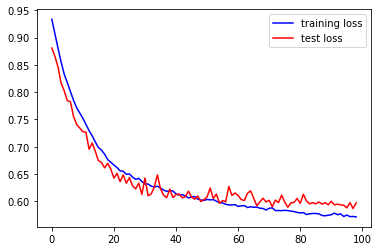

In [9]:
import matplotlib.pyplot as plt

plt.plot(train_loss[1:], "b", label="training loss")
plt.plot(test_loss[1:], "r", label="test loss")

plt.legend();

In [10]:
b_x, b_y, prediction = plot_model_direct(cnn_submeso, criterion, loader_test, optimizer,len(torch_dataset_test))

Training starts on device Tesla V100-SXM2-16GB, number of samples 1
test loss: 0.5969890776650977


In [11]:
from scipy import stats

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

corr_pred_ub = stats.pearsonr(cnn_submeso(b_x.to(device)).detach().cpu().numpy()[:,0,:,:].flatten(), b_y[:,0,:,:].flatten())
corr_pred_vb = stats.pearsonr(cnn_submeso(b_x.to(device)).detach().cpu().numpy()[:,1,:,:].flatten(), b_y[:,1,:,:].flatten())
corr_pred_wb = stats.pearsonr(cnn_submeso(b_x.to(device)).detach().cpu().numpy()[:,2,:,:].flatten(), b_y[:,2,:,:].flatten())

print("correlation between prediction and target,  u'b':",corr_pred_ub )
print("correlation between prediction and target,  v'b':",corr_pred_vb )
print("correlation between prediction and target,  w'b':",corr_pred_wb )

correlation between prediction and target,  u'b': (0.6557139715814558, 0.0)
correlation between prediction and target,  v'b': (0.6439220643644468, 0.0)
correlation between prediction and target,  w'b': (0.580826520431362, 0.0)


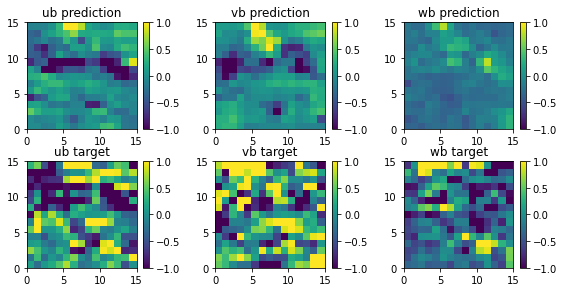

In [12]:
# visualize
it =30

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 4))
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.subplot(231)
plt.pcolor(cnn_submeso(b_x.to(device)).detach().cpu().numpy()[it,0,:,:],cmap='viridis',vmin=-1,vmax =1)
plt.title('ub prediction')
plt.colorbar()

plt.subplot(234)
plt.pcolor(b_y[it,0,:,:],cmap='viridis',vmin=-1,vmax =1)
plt.title('ub target')
plt.colorbar()

plt.subplot(232)
plt.pcolor(cnn_submeso(b_x.to(device)).detach().cpu().numpy()[it,1,:,:],cmap='viridis',vmin=-1,vmax =1)
plt.title('vb prediction')
plt.colorbar()

plt.subplot(235)
plt.pcolor(b_y[it,1,:,:],cmap='viridis',vmin=-1,vmax =1)
plt.title('vb target')
plt.colorbar()

plt.subplot(233)
plt.pcolor(cnn_submeso(b_x.to(device)).detach().cpu().numpy()[it,2,:,:],cmap='viridis',vmin=-1,vmax =1)
plt.title('wb prediction')
plt.colorbar()

plt.subplot(236)
plt.pcolor(b_y[it,2,:,:],cmap='viridis',vmin=-1,vmax =1)
plt.title('wb target')
plt.colorbar()


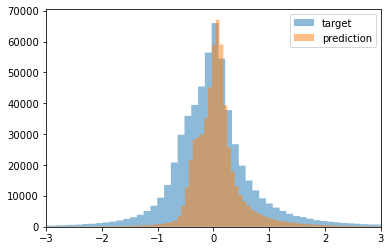

In [13]:
_=plt.hist(b_y.detach().cpu().numpy().flatten(),bins=500,alpha=0.5,histtype='stepfilled',label="target")
_=plt.hist(cnn_submeso(b_x.to(device)).detach().cpu().numpy().flatten(),bins=500,alpha=0.5,histtype='stepfilled',label="prediction")

plt.xlim([-3,3])
plt.legend()

Text(0.5, 1.0, 'wb')

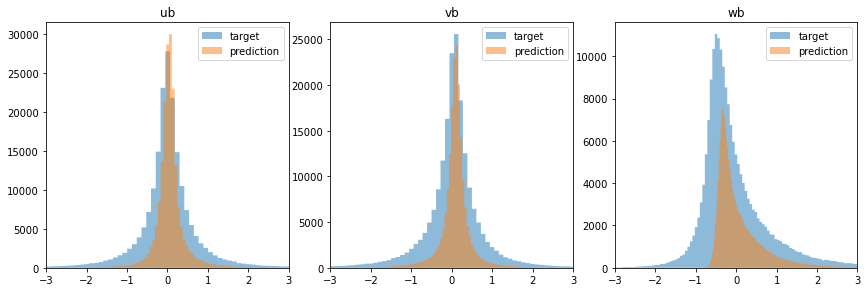

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.subplot(131)
_=plt.hist(b_y.detach().cpu().numpy()[:,0,:,:].flatten(),bins=500,alpha=0.5,histtype='stepfilled',label="target")
_=plt.hist(cnn_submeso(b_x.to(device)).detach().cpu().numpy()[:,0,:,:].flatten(),bins=500,alpha=0.5,histtype='stepfilled',label="prediction")
plt.xlim([-3,3])
plt.legend()
plt.title('ub')


plt.subplot(132)
_=plt.hist(b_y.detach().cpu().numpy()[:,1,:,:].flatten(),bins=500,alpha=0.5,histtype='stepfilled',label="target")
_=plt.hist(cnn_submeso(b_x.to(device)).detach().cpu().numpy()[:,1,:,:].flatten(),bins=500,alpha=0.5,histtype='stepfilled',label="prediction")
plt.xlim([-3,3])
plt.legend()
plt.title('vb')

plt.subplot(133)
_=plt.hist(b_y.detach().cpu().numpy()[:,2,:,:].flatten(),bins=500,alpha=0.5,histtype='stepfilled',label="target")
_=plt.hist(cnn_submeso(b_x.to(device)).detach().cpu().numpy()[:,2,:,:].flatten(),bins=500,alpha=0.5,histtype='stepfilled',label="prediction")
plt.xlim([-3,3])
plt.legend()
plt.title('wb')


In [15]:
target_da = xr.DataArray(b_y.detach().cpu().numpy(), dims=["time", "axis", "i","j"])
prediction_da = xr.DataArray(cnn_submeso(b_x.to(device)).detach().cpu().numpy(), dims=["time", "axis", "i","j"])

In [16]:
import xrft

# target vs prediction spectra
UsBs_target_spectra = xrft.isotropic_power_spectrum(target_da.isel(axis=0),dim=['i','j'], 
                                           detrend='linear', window=True).compute().mean('time')

UsBs_prediction_spectra = xrft.isotropic_power_spectrum(prediction_da.isel(axis=0),dim=['i','j'], 
                                           detrend='linear', window=True).compute().mean('time')


VsBs_target_spectra = xrft.isotropic_power_spectrum(target_da.isel(axis=1),dim=['i','j'], 
                                           detrend='linear', window=True).compute().mean('time')

VsBs_prediction_spectra = xrft.isotropic_power_spectrum(prediction_da.isel(axis=1),dim=['i','j'], 
                                           detrend='linear', window=True).compute().mean('time')


WsBs_target_spectra = xrft.isotropic_power_spectrum(target_da.isel(axis=2),dim=['i','j'], 
                                           detrend='linear', window=True).compute().mean('time')

WsBs_prediction_spectra = xrft.isotropic_power_spectrum(prediction_da.isel(axis=2),dim=['i','j'], 
                                           detrend='linear', window=True).compute().mean('time')


/home/ab10313/.local/lib/python3.9/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/home/ab10313/.local/lib/python3.9/site-packages/xrft/xrft.py:1025: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)
/home/ab10313/.local/lib/python3.9/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/home/ab10313/.local/lib/python3.9/site-packages/xrft/xrft.py:1025: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)
/home/ab10313/.local/lib/python3.9/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be de

Text(0.5, 1.0, 'WsBs')

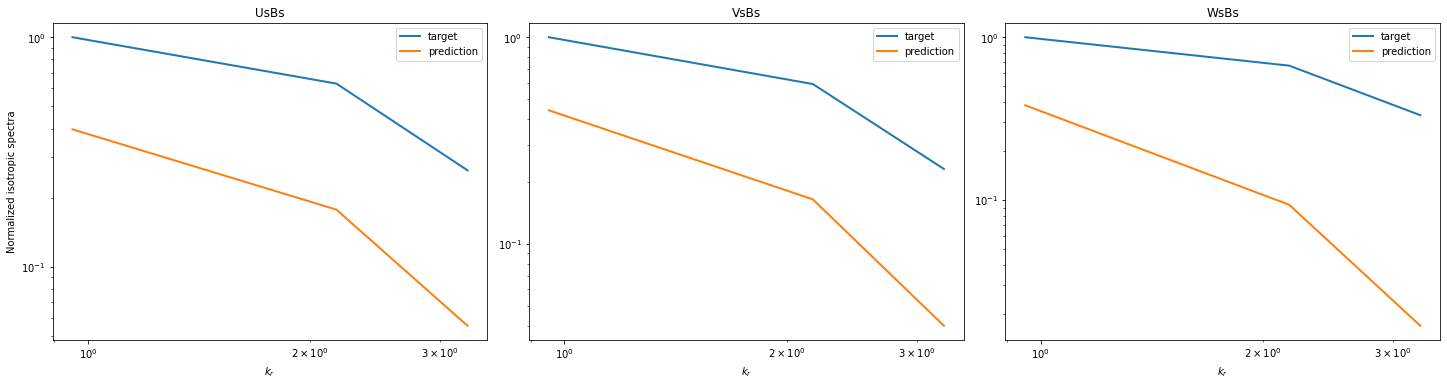

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.subplot(131)
#plt.loglog(UsBs_target_spectra.freq_r*2*np.pi, 5e-3*UsBs_target_spectra.freq_r**-2, '--',linewidth=1.5,color='black', label='k^{-2}')
#plt.loglog(UsBs_target_spectra.freq_r*2*np.pi, 2e-3*UsBs_target_spectra.freq_r**-3, '--',linewidth=1.5,color='gray', label='k^{-3}')
plt.loglog(UsBs_target_spectra.freq_r*2*np.pi, UsBs_target_spectra/UsBs_target_spectra[0],linewidth=2, label='target')
plt.loglog(UsBs_prediction_spectra.freq_r*2*np.pi, UsBs_prediction_spectra/UsBs_target_spectra[0],linewidth=2, label='prediction')
plt.legend()
plt.xlabel('$k_r$')
plt.ylabel('Normalized isotropic spectra')
plt.title('UsBs')


plt.subplot(132)
#plt.loglog(VsBs_target_spectra.freq_r*2*np.pi, 5e-3*VsBs_target_spectra.freq_r**-2, '--',linewidth=1.5,color='black', label='k^{-2}')
#plt.loglog(VsBs_target_spectra.freq_r*2*np.pi, 2e-3*VsBs_target_spectra.freq_r**-3, '--',linewidth=1.5,color='gray', label='k^{-3}')
plt.loglog(VsBs_target_spectra.freq_r*2*np.pi, VsBs_target_spectra/VsBs_target_spectra[0],linewidth=2, label='target')
plt.loglog(VsBs_prediction_spectra.freq_r*2*np.pi, VsBs_prediction_spectra/VsBs_target_spectra[0],linewidth=2, label='prediction')
plt.legend()
plt.xlabel('$k_r$')
#plt.ylabel('Normalized isotropic spectra')
plt.title('VsBs')


plt.subplot(133)
#plt.loglog(WsBs_target_spectra.freq_r*2*np.pi, 5e-3*WsBs_target_spectra.freq_r**-2, '--',linewidth=1.5,color='black', label='k^{-2}')
#plt.loglog(WsBs_target_spectra.freq_r*2*np.pi, 2e-3*WsBs_target_spectra.freq_r**-3, '--',linewidth=1.5,color='gray', label='k^{-3}')
plt.loglog(WsBs_target_spectra.freq_r*2*np.pi, WsBs_target_spectra/WsBs_target_spectra[0],linewidth=2, label='target')
plt.loglog(WsBs_target_spectra.freq_r*2*np.pi, WsBs_prediction_spectra/WsBs_target_spectra[0],linewidth=2, label='prediction')
plt.legend()
plt.xlabel('$k_r$')
#plt.ylabel('Normalized isotropic spectra')
plt.title('WsBs')